In [121]:
import openai
from openai.types import Completion, CompletionChoice, CompletionUsage
import os
import requests
from dotenv import load_dotenv
from scipy.optimize import minimize, Bounds, NonlinearConstraint
from functools import partial 

load_dotenv("/Users/gabriellelittlefair/Documents/GitHub/MSc Project/DSL/hidden.env")
%reload_ext autoreload
from Setup_Functions import *
from Class_Structures import *
from Region import * 
from Individual import * 
from Pairwise import * 

scene_descriptor = "a bedroom for a couple"

# Set up the Room (all dimensions + fixed features)

In [122]:
api_key = os.getenv('OPENAI_API_KEY')
client = openai.Client(api_key=api_key)
# If you're setting the API key directly in your script, uncomment the next line 

def remove_identical_lines(function):
    lines = function.split("\n")
    unique_lines = []
    for line in lines: 
        if line not in unique_lines:
            unique_lines.append(line)
    return("\n").join(unique_lines)

url = 'https://api.openai.com/v1/chat/completions'
headers = {
    'Authorization': f'Bearer {api_key}', 
    'Content-Type': 'application/json',
        }

# Read the contents of the .py file
file_path = '/Users/gabriellelittlefair/Documents/GitHub/MSc Project/BlankConstraints/Setup_Functions.py'
with open(file_path, 'r') as file:
    file_contents = file.read()

lang_prompt1 = """ I am designing the layout for a """ +  scene_descriptor + """. Give me the dimensions of the room, as well as the number of windows, 
doors, and sockets. For each of these, tell me the dimensions in meters, which wall it should be on, as well as where on the wall it should 
be (a value between 0 and 1 determining how far along the wall it should be). Here is an example for a room and window set up: 
{Room: width = 5, length = 6}, {Object type: window, width = 1, length = 0.1, wall = south, position = 3}. The windows and doors should all 
have length 0.1. Ensure that every object has dimensions, position, and wall. No other text please. Just the list with no commentary or explanation.
"""

lang1output = client.chat.completions.create(
    model="gpt-4o",
    messages=[{"role": "user", "content": lang_prompt1}],
    max_tokens=500
)
objects = lang1output.choices[0].message.content.split("}, {")

prompt1 = """The functions in the following file are used to create a room and out objects in it: """ + file_contents + """. The room is described 
as """ +  scene_descriptor + """. For every element in this list, """ + str(objects) + """, translate it into a function call using the file attached.
For example, given the room descriptor 'a small kitchen' as well as the list: {Room: width = 5, length = 6}, 
{Object type: window, Number: 1, width = 1, length = 0.1, wall = south, position = 0.3}, the output would be:
 kitchen = create_room(5, 6), create_fixed_object(kitchen, 'window', 1, 0.1, 'south', position = 0.3). Return only the python script. 
 No other text. Please ensure the correct number of inputs are given for each function."""

# Define the request payload
data = {
    "model": "gpt-4",
    "messages": [
        {"role": "user", "content": prompt1}
    ]
}

# Make the API call
response1 = requests.post(url, headers=headers, json=data)  
# Check the response
if response1.status_code == 200:
    response_data1 = response1.json()
    if "```python" in response_data1['choices'][0]['message']['content']:
        response1 = (response_data1['choices'][0]['message']['content'].split("```python")[1]).split("```")[0]
    elif "```" in response_data1['choices'][0]['message']['content']:
        response1 = (response_data1['choices'][0]['message']['content'].split("```")[1]).split("```")[0]
    else: 
        response1 = response_data1['choices'][0]['message']['content']
else:
    print('Failed to get a response')
    print(response1.text)

## Account for any additional function calls (of other functions) by only taking the lines in the code that are relevant to the task   
lines = response1.split("\n")
response1 = [i for i in lines if 'create_room' in i]
for line in lines[1:]: 
    if "create_fixed_object" in line: 
        response1.append(line)

response1 = ("\n").join(response1)
width = (response1.split("create_room("))[1].split(",")[0]
length = (response1.split("create_room("))[1].split(",")[1].split(")")[0]
room_name = (response1.split("create_room("))[0].split("=")[0].strip()

lang_prompt2 = """ I am designing the layout of a """ + scene_descriptor + " that is " + width + "m x " + length + """m. Interior designers
 suggest that a good layout will have different regions in the room for different functions. What regions should I use, and how many regions 
 (minimum is 1 region) should there be based on the description, as well as the size of the room (if the room is small, don't give too many regions). 
 Some rooms may only need one region and that's okay. Return this as a simple bullet list of regions to include. Return these in list of priority order. 
 Only return the list of regions. No other information please."""

lang2output = client.chat.completions.create(
        model="gpt-4o",
        messages=[{"role": "user", "content": lang_prompt2}],
        max_tokens=500
    )

print(lang2output.choices[0].message.content)

prompt2 = "Given the room name: " + room_name + ", and the regions: " + lang2output.choices[0].message.content + """, using the functions in the script, 
initialise each region. For example 'eating region' might output 'eating_region = region_setup(kitchen, 'eating', 0). No other text please, 
only the python script. Don't include the function in the output. The function is: 
def region_setup(room_name, name, index):
    '''A function that initialises the regions in a room randomly.
        Inputs:
        room_name: name of the Room
        name: str, the name of the region e.g 'sleeping'
        index: int, the index of the region (0, 1, 2, ...). First one must be 0, and the rest must be in order.
    '''
    return
"""
 # Define the request payload
data = {
    "model": "gpt-4",
    "messages": [
            {"role": "user", "content": prompt2}
            ]
    }
    
# Make the API call
response2 = requests.post(url, headers=headers, json=data)  
# Check the response
if response2.status_code == 200:
    response_data2 = response2.json()
    if "```python" in response_data2['choices'][0]['message']['content']:
        response2 = (response_data2['choices'][0]['message']['content'].split("```python")[1]).split("```")[0]
    else: 
        response2 = response_data2['choices'][0]['message']['content']
        global_context = globals().copy()
        local_context = {}  
        exec(response1 + "\n" + response2, global_context, local_context)
else:
    print('Failed to get a response')
    print(response2.text)

print(response1)
print(response2)

fixed_objects = ""
for i in range(len(local_context[room_name].fixed_objects)):
    if i < len(local_context[room_name].fixed_objects) - 1:
        fixed_objects +=local_context[room_name].fixed_objects[i].name + ", "
    else: 
        fixed_objects += local_context[room_name].fixed_objects[i].name + "."

region_names = ""
list_region_names = []
for i in range(len(local_context[room_name].regions)):
    if i < len(local_context[room_name].regions) - 1:
        region_names += local_context[room_name].regions[i].name + ", "
        list_region_names.append(local_context[room_name].regions[i].name)  
    else: 
        region_names += local_context[room_name].regions[i].name + "."
        list_region_names.append(local_context[room_name].regions[i].name)
num_primary_objects = len(list_region_names)
num_regions = len(list_region_names)

response2 = response2.replace(room_name, "local_context[room_name]")
region_setups = response2.split("\n")

- Sleeping area
- Wardrobe/Closet space
- Dressing area
- Small sitting/reading nook
room = create_room(4,5)
create_fixed_object(room, 'window', 1.5, 0.1, 'north', 0.5)
create_fixed_object(room, 'window', 1, 0.1, 'west', 0.3)
create_fixed_object(room, 'door', 0.9, 0.1, 'south', 0.7)
create_fixed_object(room, 'socket', 0.1, 0.1, 'east', 0.2)
create_fixed_object(room, 'socket', 0.1, 0.1, 'north', 0.8)
sleeping_area = region_setup(room, 'Sleeping area', 0)
wardrobe_closet_space = region_setup(room, 'Wardrobe/Closet space', 1)
dressing_area = region_setup(room, 'Dressing area', 2)
small_sitting_reading_nook = region_setup(room, 'Small sitting/reading nook', 3)


In [123]:
region_setups = []
lines = response2.split("\n")
lines2 = response2.split("\n")
for line in lines: 
    if 'region_setup' in line: 
        region_setups += [line]
        lines2.remove(line)
for i in region_setups: 
    i.replace("room", "local_context[room_name]")
print(region_setups)

["sleeping_area = region_setup(local_context[room_name], 'Sleeping area', 0)", "wardrobe_closet_space = region_setup(local_context[room_name], 'Wardrobe/Closet space', 1)", "dressing_area = region_setup(local_context[room_name], 'Dressing area', 2)", "small_sitting_reading_nook = region_setup(local_context[room_name], 'Small sitting/reading nook', 3)"]


# Get the primary objects, as well as all of their constraints. 

In [124]:
lang_prompt3 = "The room is described as " + scene_descriptor + ". Now for each one of the regions: " + lang2output.choices[0].message.content + """, 
what is the most important object to include, and what are its dimensions (give width of back of object and length of side of object but not height) 
in meters. ONLY one object per region (there can only be two of the same object if NECESSARY. If that is the case, output them as bed 1 and bed 2 or
 chair 1 and chair 2). The size of the room is """ + width + "m x " + length + """m, bear this in mind when choosing the objects and the size 
 of the objects. Give no other information please."""

lang3output = client.chat.completions.create(
        model="gpt-4o",
        messages=[{"role": "user", "content": lang_prompt3}],
        max_tokens=2000
    )

print(lang3output.choices[0].message.content)

lang_prompt4 = "For each of these objects: " + lang3output.choices[0].message.content + """, tell me all of the considerations and constraints
 for its placement within the room that depend only on fixed features in the room like walls, windows, doors, sockets, etc. and return these as a 
 bullet list for each object. Include practical things like whether it should be against a wall and what side (one of: left, right, top/back, bottom/front) 
 of it should be against a wall (don't describe this as long or short side, if its something like a headboard or the back of a sofa that would be 'back' etc.), 
 or which side should be accessible for use (most objects will need an accessible constraint e.g. front of wardrobe needs to be accessible) etc. 
 Only give these constraints and considerations, no other information."""
 
lang4output = client.chat.completions.create(
        model="gpt-4o",
        messages=[{"role": "user", "content": lang_prompt4}],
        max_tokens=2000
    )

print(lang4output.choices[0].message.content)

lang_prompt5 = """ Tell me all of the constraints and considerations between the objects in this list""" + lang3output.choices[0].message.content + """ that depend only on each other.
For example, maybe a desk should not be close to a bed, etc. Only give the constraints and considerations between objects, no other information.."""

lang5output = client.chat.completions.create(
        model="gpt-4o",
        messages=[{"role": "user", "content": lang_prompt5}],
        max_tokens=2000
    )

print(lang5output.choices[0].message.content)

- Sleeping area: Bed (1.6m x 2m)
- Wardrobe/Closet space: Wardrobe (1.5m x 0.6m)
- Dressing area: Dressing table (1.2m x 0.6m)
- Small sitting/reading nook: Chair (0.8m x 0.8m)
### Bed (1.6m x 2m)
- Place the back (headboard side) against a wall for stability and head support.
- Ensure there is enough space on both the left and right sides for easy access (roughly 0.6m on each side is generally recommended).
- Avoid placing under a window to prevent draft and for head safety.
- Keep away from doors to prevent obstruction of entry/exit.
- Consider proximity to power sockets for alarm clocks or electronic devices.

### Wardrobe (1.5m x 0.6m)
- Place the back against a wall for maximum storage efficiency.
- Ensure it's not placed against a wall with a window to avoid blocking natural light.
- Avoid placing too close to doors to prevent obstructing pathways.
- Ensure there is enough space in front for the doors to open fully (generally at least 0.8m).

### Dressing Table (1.2m x 0.6m)
- Pl

# Get the Secondary objects, as well as all of their constraints

In [125]:
lang_prompt6 = "Given a room described as: " + scene_descriptor + ", with size: " + str(width) + "m x " + str(length) + """ m with these regions within 
it:""" + region_names + ", and these primary objects already in it: " + lang3output.choices[0].message.content + """, what other objects should be added in? 
Give me 0-20 (depending on the size of the room) more objects that should be added into the room (so make sure they are the most appropriate/necessary objects). 
For each one, make sure that they make sense to go into one of the regions, and tell me which region they should go into. There can be more than one of
each object kind (eg. multiple dining chairs or multiple nightstands). Make sure to also give the dimensions of every object in meters (width of the back 
of the object and length  of the side of the object but NOT HEIGHT). Remove any objects that are not placed directly on the floor, e.g. table lamp,
and remove any objects that are mounted on the wall (e.g. paintings). Only give objects that get placed onto the floor. Give no other text in the response. 
Only the list of objects."""

lang6output = client.chat.completions.create(
        model="gpt-4o",
        messages=[{"role": "user", "content": lang_prompt6}],
        max_tokens=1000
    )

print(lang6output.choices[0].message.content)

lang_prompt7 = """For each of these objects""" + lang6output.choices[0].message.content + """, tell me all of the considerations and constraints for its placement 
within the room that depends only on fixed features in the room like walls, windows, doors, sockets, etc. (return these as a bullet list for each object). 
Include practical things like whether it should be against a wall and what side of the object (one of: left, right, top/back, bottom/front) of it should be
against a wall (don't describe this as long or short side, if its something like a headboard or the back of a sofa that would be 'back' etc.), 
or which side should be accessible for use etc. Don't include any constraints that depend on other objects. Only give these constraints and considerations, no other information. """
lang7output = client.chat.completions.create(
        model="gpt-4o",
        messages=[{"role": "user", "content": lang_prompt7}],
        max_tokens=2000
    )

print(lang7output.choices[0].message.content)

lang_prompt8 = """ Tell me all of the constraints and considerations between the objects in this list""" + lang6output.choices[0].message.content + """ as well as 
in this list """ + lang3output.choices[0].message.content + """. For example, a desk chair should have its front against the front of the desk, or the left side of one 
of the nightstands should be against the right side of the bed, etc.  Be specific with relationships between objects to include sides (one of: left, right, top/back, bottom/front) 
if appropriate, or minimum/maximum distances between objects etc.
Only give the constraints and considerations between objects, no other information."""

lang8output = client.chat.completions.create(
        model="gpt-4o",
        messages=[{"role": "user", "content": lang_prompt8}],
        max_tokens=2000
    )

print(lang8output.choices[0].message.content)

- Sleeping area: Nightstand (0.6m x 0.4m)
- Sleeping area: Nightstand (0.6m x 0.4m)
- Wardrobe/Closet space: Shoe rack (0.9m x 0.4m)
- Wardrobe/Closet space: Laundry basket (0.5m x 0.5m)
- Dressing area: Stool (0.4m x 0.4m)
- Dressing area: Full-length mirror (0.5m x 0.5m)
- Small sitting/reading nook: Small side table (0.5m x 0.5m)
- Small sitting/reading nook: Floor lamp with base (0.4m x 0.4m)
- Small sitting/reading nook: Bookshelf (0.8m x 0.4m)
- Small sitting/reading nook: Ottoman (0.5m x 0.5m)
### Sleeping Area: Nightstand (0.6m x 0.4m)
- Should be placed next to the bed.
- Placement should not block access to any doors or windows.
- Ensure easy access to nearby electrical sockets for lamps or charging devices.
- Ideally placed against a wall for stability, either left or right side depending on the bed's orientation.

### Wardrobe/Closet Space: Shoe Rack (0.9m x 0.4m)
- Should be placed against a wall, preferably within the closet or near the entrance of the wardrobe space.
- P

# Add all the objects into the room 
### Region by region. 

In [129]:
prompt4 = "Given this list of the objects: " + lang3output.choices[0].message.content +  lang6output.choices[0].message.content + ", use the file attached to create the objects with the correct parameters."
prompt4 += "The room name is: " + room_name + ", the region names are: " + region_names + "."
prompt4 += "The room is already set up, only add in the objects using the 'create_moving_object' function."
prompt4 += "The objects should be added in the correct regions. I want the objects to be added region by region (i.e. all objects from region 0 should be added before region 1 objects are added). "
prompt4 += "This is the file: " + file_contents
prompt4 += "No extra text, only the function calls. Don't have 'python' at the start of the code. Do not define ANY functions, only call them."

# Define the request payload
data = {
    "model": "gpt-4o",
    "messages": [
            {"role": "user", "content": prompt4}
            ]
    }
    
# Make the API call
response4 = requests.post(url, headers=headers, json=data)  
# Check the response
if response4.status_code == 200:
    response_data4 = response4.json()


    if "```" in response_data4['choices'][0]['message']['content']:
        list_objects = (response_data4['choices'][0]['message']['content']).split("\n")[1:-1]
        response4_1 = ""
        for i in range(len(list_objects)):
            response4_1 += list_objects[i] + "\n"
    else: 
        lines = response_data4['choices'][0]['message']['content'].split("\n")
        response4_1 = []
        for line in lines: 
            if "create_moving_object" in line: 
                response4_1.append(line)
        response4_1 = ("\n").join(response4_1)
    
    response4_1 = response4_1.replace("create_moving_object(room,", "create_moving_object(" + room_name + ",")
    response4 = remove_identical_lines(response4_1).replace(room_name, "local_context[room_name]")

else:
    print('Failed to get a response')
    print(response4.text)

strings = response4.split("create_moving_object(local_context[room_name],")
primary_objects = []
for string in strings[1:]:
    if "'" in string: 
        primary_objects.append(string.split("'")[1])
    else:
        primary_objects.append(string.split('"')[1])

print(response4)
object_areas = 0
room_area = float(width) * float(length)
object_sizes = response4.split("\n")
wl = []
for string in object_sizes: 
    if "create_moving_object" in string: 
        sub_strings = string.split(",")
        for sub_string in sub_strings: 
            if (sub_string.replace(" ", "")).replace(".", "").isnumeric():
                wl.append(float(sub_string.replace(" ", "")))

for i in range(len(wl)//2):
    object_areas += wl[2*i] * wl[2*i + 1]

percent_of_room = 100 * object_areas/room_area
print(percent_of_room)

create_moving_object(local_context[room_name], 'bed', 1.6, 2.0, 'Sleeping area', 0)
create_moving_object(local_context[room_name], 'nightstand', 0.6, 0.4, 'Sleeping area', 1)
create_moving_object(local_context[room_name], 'nightstand', 0.6, 0.4, 'Sleeping area', 2)

create_moving_object(local_context[room_name], 'wardrobe', 1.5, 0.6, 'Wardrobe/Closet space', 3)
create_moving_object(local_context[room_name], 'shoe rack', 0.9, 0.4, 'Wardrobe/Closet space', 4)
create_moving_object(local_context[room_name], 'laundry basket', 0.5, 0.5, 'Wardrobe/Closet space', 5)
create_moving_object(local_context[room_name], 'dressing table', 1.2, 0.6, 'Dressing area', 6)
create_moving_object(local_context[room_name], 'stool', 0.4, 0.4, 'Dressing area', 7)
create_moving_object(local_context[room_name], 'full-length mirror', 0.5, 0.5, 'Dressing area', 8)
create_moving_object(local_context[room_name], 'chair', 0.8, 0.8, 'Small sitting/reading nook', 9)
create_moving_object(local_context[room_name], 'small si

In [130]:
object_creations = ['' for i in range(2*num_regions)]
lines = response4.split("\n")
for i in range(num_regions):
    sub_lines = [line for line in lines if list_region_names[i] in line]
    object_creations[2*i] = sub_lines[0]
    object_creations[2*i + 1] = "\n".join(sub_lines[1:])

In [131]:
primary_objects = []
secondary_objects = []
primary_object_indices = []

for name in list_region_names:
    lines = [i for i in response4.split("\n") if name in i and 'create_moving_object' in i]
    if "'" in lines[0]: 
        name = lines[0].split("'")[1]
    else:
        name = lines[0].split('"')[1]
    index = int(lines[0].split(", ")[-1].split(")")[0])
    primary_object_indices += [index]
    primary_objects += [name]

    for line in lines[1:]:
        if "'" in line: 
            name = line.split("'")[1]
        else:
            name = line.split('"')[1]
        secondary_objects += [name]

secondary_object_indices = [i for i in range(len(secondary_objects) + len(primary_objects)) if i not in primary_object_indices]
print(str(primary_object_indices), str(primary_objects), str(secondary_object_indices), str(secondary_objects))

[0, 3, 6, 9] ['bed', 'wardrobe', 'dressing table', 'chair'] [1, 2, 4, 5, 7, 8, 10, 11, 12, 13] ['nightstand', 'nightstand', 'shoe rack', 'laundry basket', 'stool', 'full-length mirror', 'small side table', 'floor lamp with base', 'bookshelf', 'ottoman']


In [132]:
file_path2 = '/Users/gabriellelittlefair/Documents/GitHub/MSc Project/BlankConstraints/Individual.py'
with open(file_path2, 'r') as file:
    file_contents2 = file.read()

file_path3 = '/Users/gabriellelittlefair/Documents/GitHub/MSc Project/BlankConstraints/Pairwise.py'
with open(file_path3, 'r') as file:
    file_contents3 = file.read()

prompt5 = "Given the room_name " + room_name + " as well as the primary objects: " + str(primary_objects) + """, as well as their 
indices""" + str(primary_object_indices) + " and these constraints: " + lang4output.choices[0].message.content + """. Using the script attached, 
transform each constraint into function calls that will ensure that the primary objects are set up correctly. Match each constraint to the closest 
function in the script file by using the docstrings. If you cannot find a function that matches the constraint, leave it out. 
Here is the first script: """ + file_contents2 + """. For the second script, I want you to transform the pairwise constraints into function calls.
Here is the second script: """ + file_contents3 + ", and here is the list of pairwise constraints: " + lang5output.choices[0].message.content + """I want 
the output to begin with: def optimize_primary_objects(positions, room): \n output = 0,  followed by each constraint function call added to the output, 
and then the output returned. Ensure to include the functions ind_in_bounds, and ind_no_overlap. No extra text please, only the functions and the output. 
Do not define ANY functions, only call them. ENSURE that all parameters match docstrings."""

# Define the request payload
data = {
    "model": "gpt-4o",
    "messages": [
            {"role": "user", "content": prompt5}
            ]
    }
    
# Make the API call
response5 = requests.post(url, headers=headers, json=data)  
# Check the response
if response5.status_code == 200:
    response_data5 = response5.json()

    if "```" in response_data5['choices'][0]['message']['content']:
        list_objects = (response_data5['choices'][0]['message']['content']).split("\n")[1:-1]
        response5_1 = ""
        for i in range(len(list_objects)):
            response5_1 += list_objects[i] + "\n"
    else: 
        
        response5_1 = response_data5['choices'][0]['message']['content']

    response5 = remove_identical_lines(response5_1)
    lines = response5.split("\n")
    for line in lines: 
        if "ind_in_region" in line: 
            lines.remove(line)
    response5 = ("\n").join(lines)
    print(response5)
    global_context = globals().copy()
    local_context = {}  
    exec(response5, global_context, local_context)
else:
    print('Failed to get a response')
    print(response5.text)


def optimize_primary_objects(positions, room): 
    output = 0
    output += ind_next_to_wall(positions, room, 0, 'back')
    output += ind_accessible(positions, room, 0, ['left', 'right'])
    output += ind_away_from_fixed_object(positions, room, 0, 'window')
    output += ind_away_from_fixed_object(positions, room, 0, 'door')
    output += ind_close_to_fixed_object(positions, room, 0, 'socket')
    
    output += ind_next_to_wall(positions, room, 3, 'back')
    output += ind_not_block_fixed_object(positions, room, 3, 'window')
    output += ind_away_from_fixed_object(positions, room, 3, 'door')
    output += ind_next_to_wall(positions, room, 6, 'back')
    output += ind_close_to_fixed_object(positions, room, 6, 'socket')
    output += ind_not_block_fixed_object(positions, room, 6, 'window')
    output += ind_next_to_wall(positions, room, 9, 'back')
    output += ind_away_from_fixed_object(positions, room, 9, 'door')
    output += ind_not_block_fixed_object(positions, room, 9, 'window

# Find the Primary Optimization Functions

In [158]:
primary_functions = []
lines = response5.split("\n")
for i in primary_object_indices[::-1]:#range(num_primary_objects - 1, -1, -1):
    print(i)
    lines_to_remove = []
    ## I need to split the optimization function into multiple different functons
    function = ("\n").join(lines[:2])
    for line in lines:
        sub_sections = line.split(room_name + ", ")
        if "ind_no_overlap" in line:
            function += "\n" + line
        if "ind_in_bounds" in line:
            function += "\n" + line
        if "return" in line: 
            function += "\n" + line
        for j in sub_sections: 
            if str(i) + "," in j or str(i) + ")" in j:
                function += "\n" + line
                lines_to_remove += [line]
                break 
    for line in lines_to_remove:
        lines.remove(line)
    print(function)
    primary_functions = [function] + primary_functions

9
def optimize_primary_objects(positions, room): 
    output = 0
    output += ind_next_to_wall(positions, room, 9, 'back')
    output += ind_away_from_fixed_object(positions, room, 9, 'door')
    output += ind_not_block_fixed_object(positions, room, 9, 'window')
    output += ind_close_to_fixed_object(positions, room, 9, 'socket')
    output += ind_in_bounds(positions, room)
    output += ind_no_overlap(positions, room)
    output += p_away_from(positions, room, 0, 9, 0.8)
    output += p_away_from(positions, room, 3, 9, 0.8)
    output += p_away_from(positions, room, 6, 9, 0.8)
    return output
6
def optimize_primary_objects(positions, room): 
    output = 0
    output += ind_next_to_wall(positions, room, 6, 'back')
    output += ind_close_to_fixed_object(positions, room, 6, 'socket')
    output += ind_not_block_fixed_object(positions, room, 6, 'window')
    output += ind_in_bounds(positions, room)
    output += ind_no_overlap(positions, room)
    output += p_away_from(positions, ro

In [166]:
new_primary_functions = primary_functions.copy()
primary_accessible_constraints = [[] for i in range(num_primary_objects)]
for obj_index in range(num_primary_objects):
    for i in primary_functions[obj_index].split("\n"):
        if "ind_accessible" in i:# and str(primary_object_indices[obj_index]) in i: 
            primary_accessible_constraints[obj_index].append(i)

    primary_accessible_constraints[obj_index] = "\n" +("\n").join(primary_accessible_constraints[obj_index])

for i in range(num_regions):
    if i > 0: 
        for j in primary_accessible_constraints[i - 1].split("\n"):
            if j not in primary_accessible_constraints[i]:
                primary_accessible_constraints[i] += "\n" + j

for i in range(num_regions): 
    for j in primary_accessible_constraints[i].split("\n"):
        if j not in primary_functions[i].split("\n"):
            new_primary_functions[i] = primary_functions[i].split("return")[0] + "\n" + j + "\n    return" + primary_functions[i].split("return")[1]

def optimize_primary_objects(positions, room): 
    output = 0
    output += ind_next_to_wall(positions, room, 0, 'back')
    output += ind_accessible(positions, room, 0, ['left', 'right'])
    output += ind_away_from_fixed_object(positions, room, 0, 'window')
    output += ind_away_from_fixed_object(positions, room, 0, 'door')
    output += ind_close_to_fixed_object(positions, room, 0, 'socket')
    output += ind_in_bounds(positions, room)
    output += ind_no_overlap(positions, room)
    

    return output
def optimize_primary_objects(positions, room): 
    output = 0
    output += ind_next_to_wall(positions, room, 3, 'back')
    output += ind_not_block_fixed_object(positions, room, 3, 'window')
    output += ind_away_from_fixed_object(positions, room, 3, 'door')
    output += ind_in_bounds(positions, room)
    output += ind_no_overlap(positions, room)
    output += p_away_from(positions, room, 0, 3, 0.8)
    
    output += ind_accessible(positions, room, 0, ['left', 'right'])
    r

# Get the Secondary Optimization Functions

In [167]:
objects_per_region =[[] for i in range(num_regions)]
for i in range(len(primary_objects)):
    if i < len(primary_objects) - 1:
        objects_per_region[i] = [j for j in range(primary_object_indices[i], primary_object_indices[i + 1])]
    else:
        objects_per_region[i] = [j for j in range(primary_object_indices[i], len(primary_objects) + len(secondary_objects))]
print(objects_per_region)

[[0, 1, 2], [3, 4, 5], [6, 7, 8], [9, 10, 11, 12, 13]]


In [168]:
prompt6 = "Given the primary objects: " + str(primary_objects) + " and their indices: " + str(primary_object_indices) + """, as well as the secondary
objects """ + lang6output.choices[0].message.content + " and their indices " + str(secondary_object_indices) + """, and their individual 
constraints: """ + lang7output.choices[0].message.content + ", and these are the region names: " + region_names + """. Using the script attached, 
transform each constraint into function calls that will ensure that the secondary objects are set up correctly. Match each constraint to the closest
function in the script file by using the docstrings. If you cannot find a function that matches the constraint, leave it out. 
Here is the first script: """ + file_contents2 + """. For the second script, I want you to transform the pairwise constraints into function calls. 
Here is the second script: """ + file_contents3 + ", and here is the list of pairwise constraints: " + lang8output.choices[0].message.content + """. 
I want the output to begin with: ’def optimize_secondary_objects(positions, room): \n output = 0\n’, followed by each constraint function call 
added to the output, (each line should begin with 'output +='). Ensure to use ind_in_bounds, and ind_no_overlap. 
Also ensure to use ind_in_region for each object. Do not define ANY functions, only call them. No extra text please, only the functions and the output."""

# Define the request payload.
data = {
    "model": "gpt-4o",
    "messages": [
            {"role": "user", "content": prompt6}
            ]
    }
    
# Make the API call
response6 = requests.post(url, headers=headers, json=data)  
# Check the response
if response6.status_code == 200:

    if "```" in response6.json()['choices'][0]['message']['content']:
        list_objects = (response6.json()['choices'][0]['message']['content']).split("\n")[1:-1]
        response6_1 = ""
        for i in range(len(list_objects)):
            response6_1 += list_objects[i] + "\n"
    else: 
        
        response6_1 = response6.json()['choices'][0]['message']['content']
    
    indent1 = response6_1.split("output")[0].split("\n")[1]
    response6 = "def optimize_secondary_objects(positions, room):\n" + indent1 + "output = 0\n"
    response6 += indent1 + "\n" + ("\n").join((response6_1.split("return")[0]).split("\n")[2:]) + "\n" + indent1 + "return output \n"
    print(response6)

else:
    print('Failed to get a response')
    print(response6.text)



def optimize_secondary_objects(positions, room):
    output = 0
    

    # Sleeping Area Nightstands
    output += ind_in_region(positions, room, 1, 'Sleeping area')
    output += ind_in_region(positions, room, 2, 'Sleeping area')
    output += ind_next_to_wall(positions, room, 1, 'bottom')
    output += ind_next_to_wall(positions, room, 2, 'bottom')
    output += ind_close_to_fixed_object(positions, room, 1, 'socket', max_dist=0.5)
    output += ind_close_to_fixed_object(positions, room, 2, 'socket', max_dist=0.5)
    output += ind_away_from_fixed_object(positions, room, 1, 'window', min_dist=2.0)
    output += ind_away_from_fixed_object(positions, room, 2, 'window', min_dist=2.0)
    output += ind_away_from_fixed_object(positions, room, 1, 'door', min_dist=2.0)
    output += ind_away_from_fixed_object(positions, room, 2, 'door', min_dist=2.0)
    output += p_next_to(positions, room, 0, 1, side1='right', side2='left')
    output += p_next_to(positions, room, 0, 2, side1='left', side2

In [169]:
secondary_functions = ['' for i in range(num_regions)]
lines = response6.split("\n")
for i in range(num_regions - 1, -1, -1):
    function = ("\n").join(lines[:2])
    function += ("\n").join(primary_accessible_constraints[:i + 1])
        

    for obj_index in objects_per_region[i]:
        lines_to_remove = []
        for line in lines:
            sub_sections = line.split(room_name + ", ")

            if "ind_accessible" in line and str(obj_index) in line:
                function += "\n" + line

            for j in sub_sections: 
                if str(obj_index) + "," in j or str(obj_index) + ")" in j:
                    function += "\n" + line
                    lines_to_remove += [line]
                    break 
    
        for line in lines_to_remove:
            if line in lines: 
                lines.remove(line)
    for line in lines: 
        if "ind_no_overlap" in line:
            function += "\n" + line
        if "ind_in_bounds" in line:
            function += "\n" + line
        if "return" in line: 
            function += "\n" + line

            
    secondary_functions[i] = remove_identical_lines(function)

In [174]:
new_secondary_functions = secondary_functions.copy()
secondary_accessible_constraints = [[] for i in range(len(secondary_objects))]
for region in range(num_regions):
    for i in secondary_functions[region].split("\n"):
        if "ind_accessible" in i:
            secondary_accessible_constraints[region].append(i)

    secondary_accessible_constraints[region] = "\n" +("\n").join(secondary_accessible_constraints[region])

for i in range(num_regions):
    if i > 0: 
        for j in secondary_accessible_constraints[i - 1].split("\n"):
            if j not in secondary_accessible_constraints[i]:
                secondary_accessible_constraints[i] += "\n" + j

for i in range(num_regions): 
    for j in secondary_accessible_constraints[i].split("\n"):
        if j not in secondary_functions[i].split("\n"):
            new_secondary_functions[i] = secondary_functions[i].split("return")[0] + "\n" + j + "\n    return" + secondary_functions[i].split("return")[1]

secondary_functions = new_secondary_functions.copy()

def optimize_secondary_objects(positions, room):
    output = 0
    output += ind_accessible(positions, room, 0, ['left', 'right'])

    output += ind_next_to_wall(positions, room, 6, 'bottom')
    output += p_infront(positions, room, 7, 6, dist=0.3)
    output += p_away_from(positions, room, 8, 6, min_dist=0.5)
    output += ind_in_region(positions, room, 7, 'Dressing area')
    output += ind_next_to_wall(positions, room, 7, 'bottom')
    output += ind_in_region(positions, room, 8, 'Dressing area')
    output += ind_in_bounds(positions, room)
    output += ind_no_overlap(positions, room)
    
    output += ind_accessible(positions, room, 5, ['top'])
    
    output += ind_accessible(positions, room, 4, ['top'])
    return output 


In [175]:
final_function = "def optimize(positions, room):\n"
final_function += ("\n").join(response5.split("\n")[1:]).split("return")[0] + "\n"
final_function += response6.split("output = 0")[1] + "\n"

# Run the code !

Adding in the primary object:  bed
Room [<Class_Structures.Object object at 0x30688a1c0>]
New best result found. Cost:  2.2127182028109917
New best result found. Cost:  0.4206168109330419
New best result found. Cost:  0.4206124266007243
New best result found. Cost:  0.42061119781511


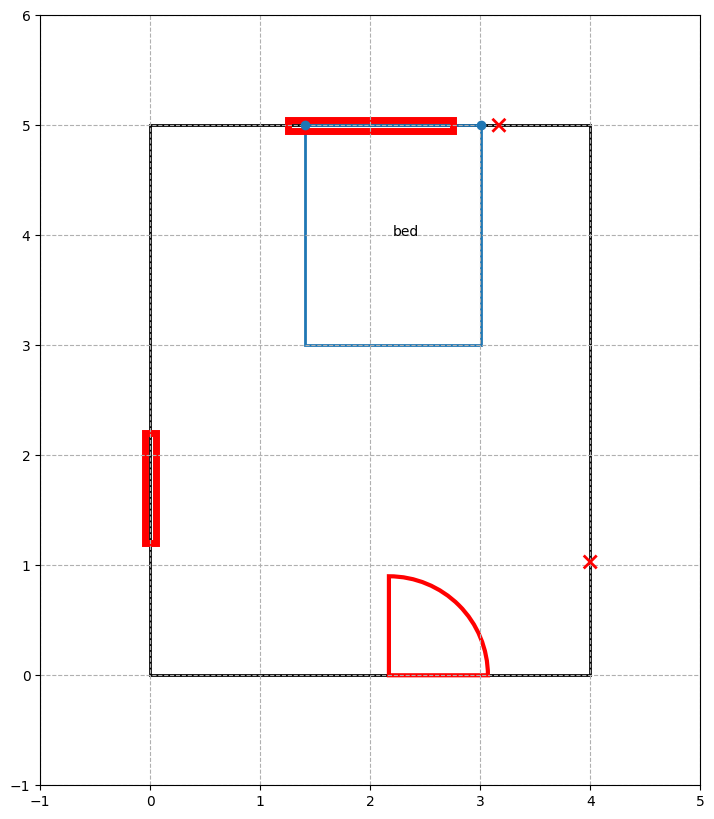

Adding in the secondary objects:  ['nightstand', 'nightstand']
New best result found. Cost:  20.9798800444379 overlap:  0 bounds:  1.396211365085998e-14
New best result found. Cost:  19.6519671668423 overlap:  0 bounds:  0.17961182010354604
New best result found. Cost:  11.287605107429128 overlap:  0 bounds:  0.0551908728822485
New best result found. Cost:  11.254320646330003 overlap:  0 bounds:  0.37149378199663896
New best result found. Cost:  10.772341907633159 overlap:  7.118807378489568e-05 bounds:  0.23989068328420182
New best result found. Cost:  5.238031488362094 overlap:  0 bounds:  0.3455775081261433
New best result found. Cost:  5.238011806959122 overlap:  0 bounds:  0.3489569195269581
New best result found. Cost:  3.481811009821157 overlap:  0 bounds:  0.14509047945237002


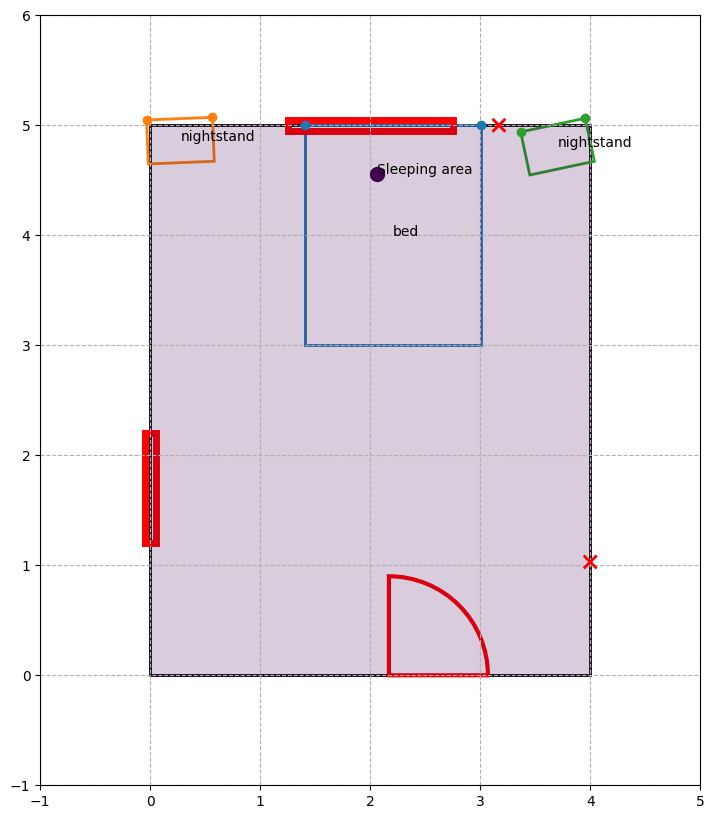

Adding in the primary object:  wardrobe
Room [<Class_Structures.Object object at 0x30688a1c0>, <Class_Structures.Object object at 0x306d2eca0>, <Class_Structures.Object object at 0x306d29a60>, <Class_Structures.Object object at 0x306a91e50>]
New best result found. Cost:  0.20733059995447434
New best result found. Cost:  0.20732946935085772


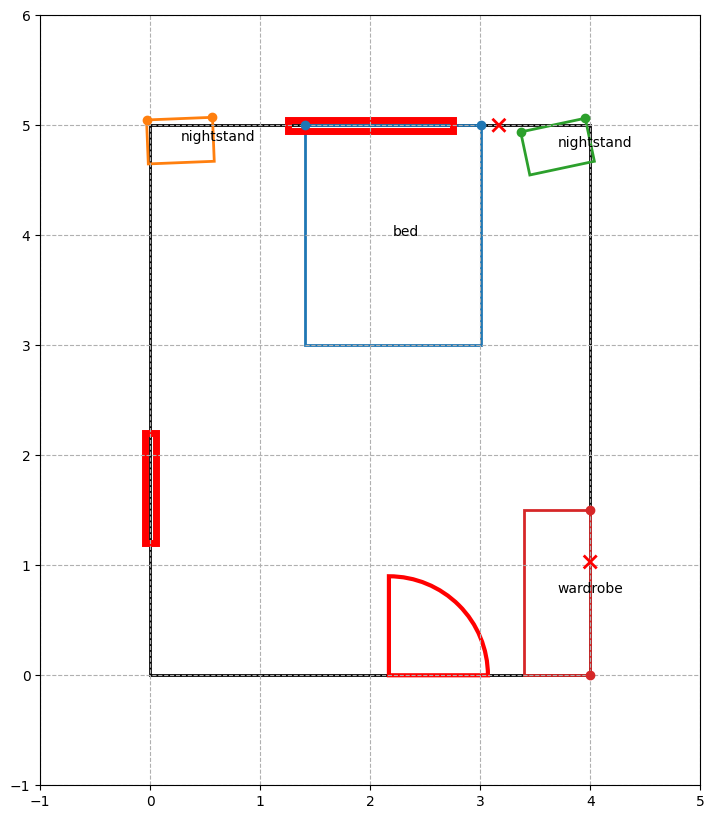

Adding in the secondary objects:  ['shoe rack', 'laundry basket']


TypeError: ind_close_to_fixed_object() got an unexpected keyword argument 'min_dist'

In [184]:
## Run the room setup 
global_context = globals().copy()
local_context = {}
exec(response1, global_context, local_context)

for region in range(num_regions):
    exec(primary_functions[region], global_context, local_context) # define the very first optimizaton function 
    ## Now want to add in the first primary object
    exec(region_setups[region] + "\n" + object_creations[2*region]) # add in the region
    print("Adding in the primary object: ", primary_objects[region])

    options = {'maxiter': 300, 'ftol': 1e-6}
    iters = 0
    min_fun = np.Inf
    room = local_context[room_name]
    print("Room", room.moving_objects)
    func = local_context['optimize_primary_objects']
    while min_fun > 1e-2 and iters < 50:
        positions = np.zeros(3)
        for i in range(len(room.moving_objects) - len(room.fm_indices)):
            positions[3*i] = np.random.uniform(0, room.width)
            positions[3*i + 1] = np.random.uniform(0, room.length)
            positions[3*i + 2] = np.random.uniform(0, 2*np.pi) 
        res = minimize(func, positions, args = (room), method = 'SLSQP', options = options) 
        iters += 1
        if res.fun < min_fun:
            if not ind_no_overlap(res.x, room) > 0.4 and not ind_in_bounds(res.x, room) > 0.4:
                min_fun = res.fun
                best_res = res
                print("New best result found. Cost: ", min_fun)

    
    for i in range(len(room.fm_indices), len(room.moving_objects)): 
        j = i - len(room.fm_indices)
        room.moving_objects[i].position = best_res.x[3*j:3*j + 3] 
    room.draw() 
    prime_index = primary_object_indices[region]
    room.regions[region].x, room.regions[region].y = room.moving_objects[prime_index].position[0], room.moving_objects[prime_index].position[1]
    prev_cost = min_fun 

    room.fm_indices += [i for i in range(len(room.fm_indices), len(room.moving_objects))]
    
    exec(object_creations[2*region + 1]) # add in the secondary objects for the region
    exec(secondary_functions[region], global_context, local_context) # define the optimization function for the secondary objects

    room = local_context[room_name]
    func = local_context['optimize_secondary_objects']

    print("Adding in the secondary objects: ", [room.moving_objects[i].name for i in objects_per_region[region]][1:])

    num = len(room.moving_objects) - len(room.fm_indices)
    bounds = Bounds([-10] * 3 * num, [room.width + 10, room.length + 10, np.Inf] * num)
    iters = 0
    min_fun = np.Inf
    while min_fun > 5e-2 and iters < 50:

        positions = np.zeros(3*num)
        for i in range(num):
            positions[3*i] = np.random.uniform(0, room.width)
            positions[3*i + 1] = np.random.uniform(0, room.length)
            positions[3*i + 2] = np.random.uniform(0, 2*np.pi) 
        res = minimize(func, positions, args = (room), method = 'SLSQP', options = options, bounds = bounds)
        iters += 1
        if res.fun < min_fun:
            if not ind_no_overlap(res.x, room) > 1e-2 and not ind_in_bounds(res.x, room) > 0.4:
                min_fun = res.fun 
                best_res = res
                print("New best result found. Cost: ", min_fun, "overlap: ", ind_no_overlap(res.x, room), "bounds: ", ind_in_bounds(res.x, room))
    
    for i in range(len(room.fm_indices), len(room.moving_objects)): 
        j = i - len(room.fm_indices)
        room.moving_objects[i].position = best_res.x[3*j:3*j + 3] 

    room.regions[region].x = np.mean([i.position[0] for i in room.moving_objects if i.region == list_region_names[region]])
    room.regions[region].y = np.mean([i.position[1] for i in room.moving_objects if i.region == list_region_names[region]])

    room.draw(draw_regions = True) 

    room.fm_indices += [i for i in range(len(room.fm_indices), len(room.moving_objects))]
    prev_cost = min_fun 

New best result found. Cost:  26.4225773297641


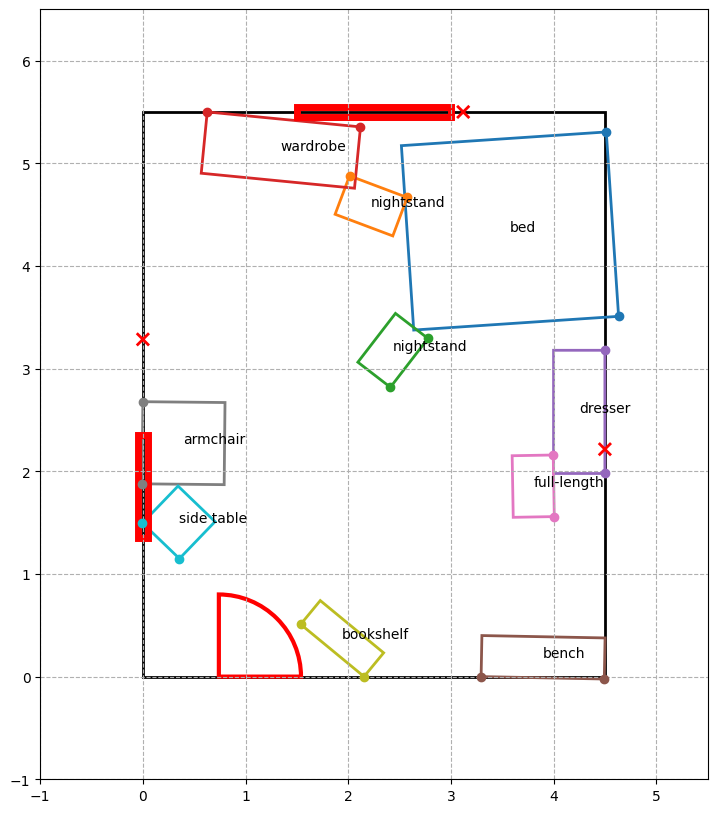

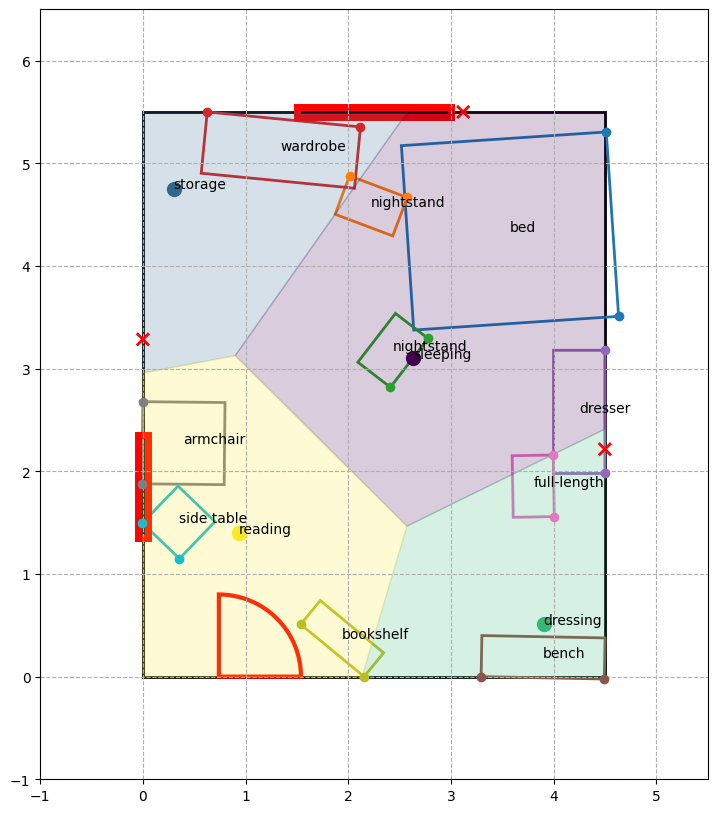

In [82]:
exec(final_function, global_context, local_context)
room = local_context[room_name]
func = local_context['optimize']
room.fm_indices = []
positions = np.zeros(3*len(room.moving_objects))
for i in range(len(room.moving_objects)):
    positions[3*i] = room.moving_objects[i].position[0]
    positions[3*i + 1] = room.moving_objects[i].position[1]
    positions[3*i + 2] = room.moving_objects[i].position[2]
res = minimize(func, positions, args = (room), method = 'SLSQP', options = options) 

for i in range(len(room.moving_objects)): 
    room.moving_objects[i].position = res.x[3*i:3*i + 3] 
room.draw() 
room.draw(draw_regions = True)